In [1]:
pip install moviepy scipy pydub

MoviePy - Writing audio in extracted_audio.wav


MoviePy - Done.


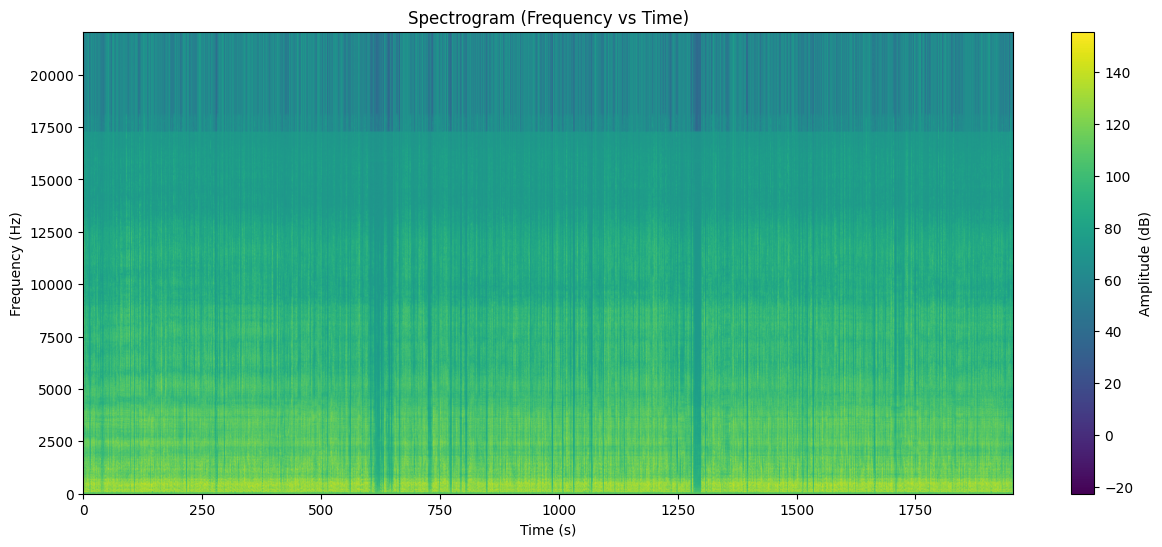

In [6]:
import numpy as np
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
from scipy.fft import fft
import matplotlib.pyplot as plt


def extract_audio_from_video(video_path, audio_output_path):
    """
    비디오에서 오디오를 추출하여 지정한 경로에 저장하는 함수.
    """
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_output_path)
    return audio_output_path


def load_audio_and_convert_to_mono(audio_path):
    """
    오디오 데이터를 로드하고 스테레오 데이터를 모노로 변환하는 함수.
    """
    audio = AudioSegment.from_file(audio_path).set_channels(1)
    sample_rate = audio.frame_rate
    samples = np.array(audio.get_array_of_samples())
    duration = len(samples) / sample_rate  # 총 길이(초)
    return audio, samples, sample_rate, duration


def perform_fft_analysis(audio, sample_rate, window_size_ms=1000, step_size_ms=500):
    """
    오디오 데이터에 대해 시간별 FFT 분석을 수행하는 함수.
    """
    window_size = 1000  # 분석할 창의 크기(밀리초)
    step_size = 500     # 이동 크기(밀리초)
    num_samples_per_window = sample_rate * window_size // 1000

    time_points = []
    freq_data = []

    for start_time in range(0, len(audio), step_size):
      segment = audio[start_time:start_time + window_size]
      if len(segment) == 0:  # 창이 넘어가면 종료
          break

      # 스테레오 데이터가 있을 경우 모노로 변환된 데이터를 샘플로 추출
      segment_samples = np.array(segment.get_array_of_samples())

      # 길이가 부족한 경우 패딩
      if len(segment_samples) < num_samples_per_window:
          segment_samples = np.pad(segment_samples, (0, num_samples_per_window - len(segment_samples)), mode='constant')

      # FFT 계산
      fft_result = fft(segment_samples)
      fft_magnitude = np.abs(fft_result)[:len(fft_result) // 2]  # 대칭이므로 절반만 사용
      freq_data.append(fft_magnitude)
      time_points.append(start_time / 1000)

    # 4. 시각화
    freq_data = np.array(freq_data)  # 행렬 변환
    freq_data = freq_data.T          # 주파수 데이터를 전치

    time_points = np.array(time_points)
    return freq_data, time_points


# 실행 순서
video_path = "/content/2_1_표본추출법.mp4"
audio_path = "extracted_audio.wav"

# 1. 비디오에서 오디오 추출
extract_audio_from_video(video_path, audio_path)

# 2. 오디오 데이터 로드 및 변환
audio, samples, sample_rate, duration = load_audio_and_convert_to_mono(audio_path)

# 3. FFT 분석
freq_data, time_points = perform_fft_analysis(audio, sample_rate, window_size_ms=1000, step_size_ms=500)

# 4. 시각화
# 히트맵(Heatmap)
plt.figure(figsize=(15, 6))
plt.imshow(
    20 * np.log10(freq_data + 1e-10),  # 로그 스케일로 변환
    aspect='auto',
    origin='lower',
    extent=[time_points.min(), time_points.max(), 0, sample_rate / 2]
)
plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (Frequency vs Time)")
plt.show()

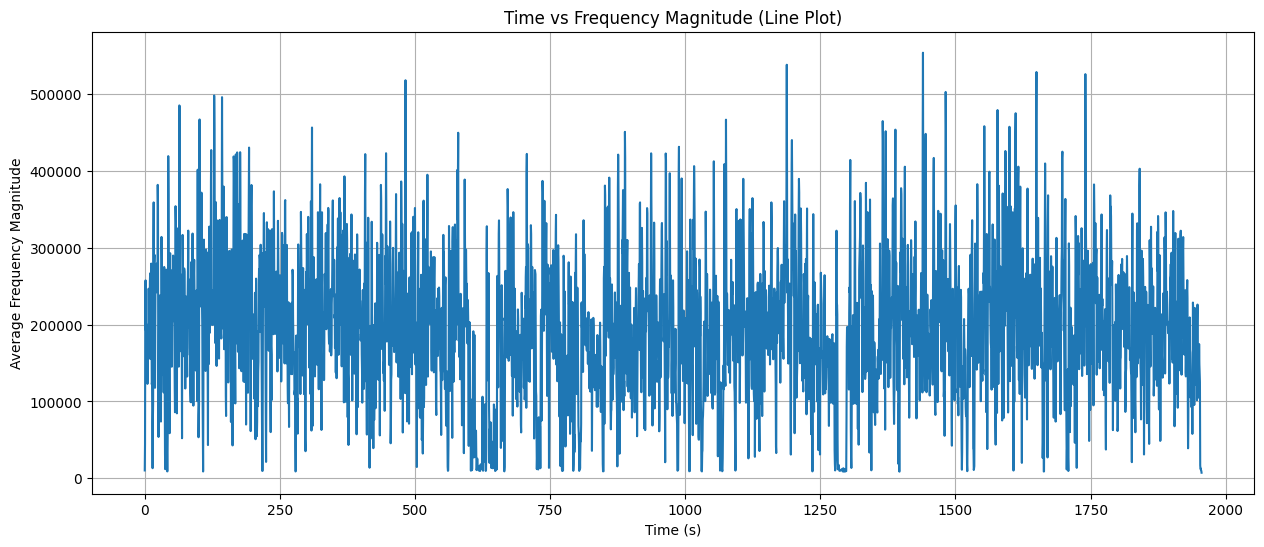

In [7]:
# 선 그래프(Line plot)
# FFT 결과의 평균을 시간에 따라 시각화
avg_freq_data = np.mean(freq_data, axis=0)

plt.figure(figsize=(15, 6))
plt.plot(time_points, avg_freq_data)
plt.xlabel("Time (s)")
plt.ylabel("Average Frequency Magnitude")
plt.title("Time vs Frequency Magnitude (Line Plot)")
plt.grid(True)
plt.show()

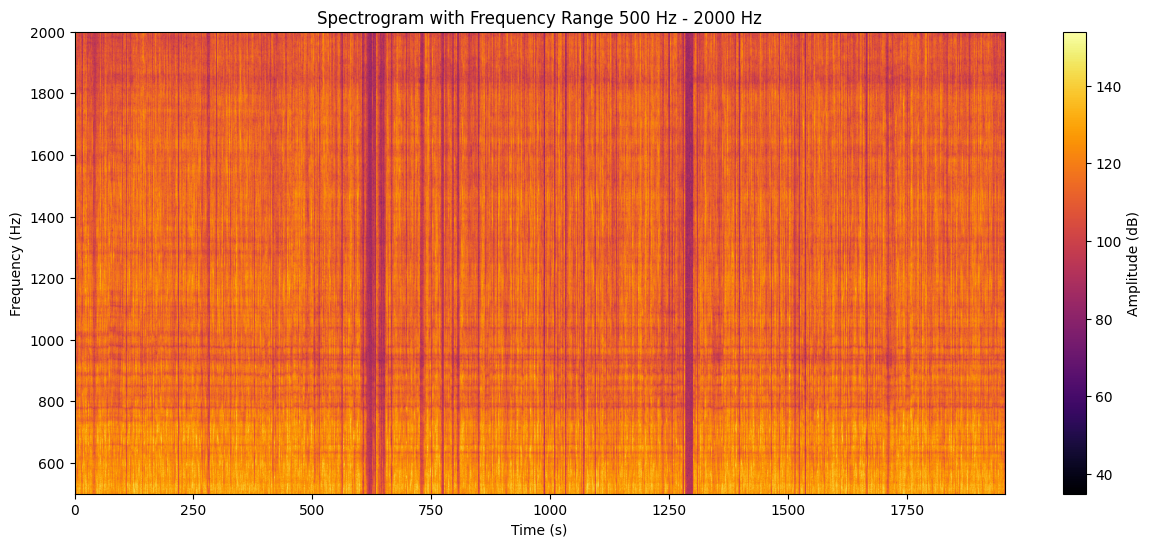

In [9]:
# 스펙트로그램(3차원)
# 특정 주파수 범위(예: 500Hz - 2000Hz)만 표시
freq_range = (500, 2000)
freq_idx = np.where((np.linspace(0, sample_rate / 2, freq_data.shape[0]) >= freq_range[0]) &
                    (np.linspace(0, sample_rate / 2, freq_data.shape[0]) <= freq_range[1]))[0]

plt.figure(figsize=(15, 6))
plt.imshow(
    20 * np.log10(freq_data[freq_idx, :] + 1e-10),
    aspect='auto',
    origin='lower',
    extent=[time_points.min(), time_points.max(), freq_range[0], freq_range[1]],
    cmap='inferno'  # 다른 컬러맵
)
plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Spectrogram with Frequency Range {freq_range[0]} Hz - {freq_range[1]} Hz")
plt.show()

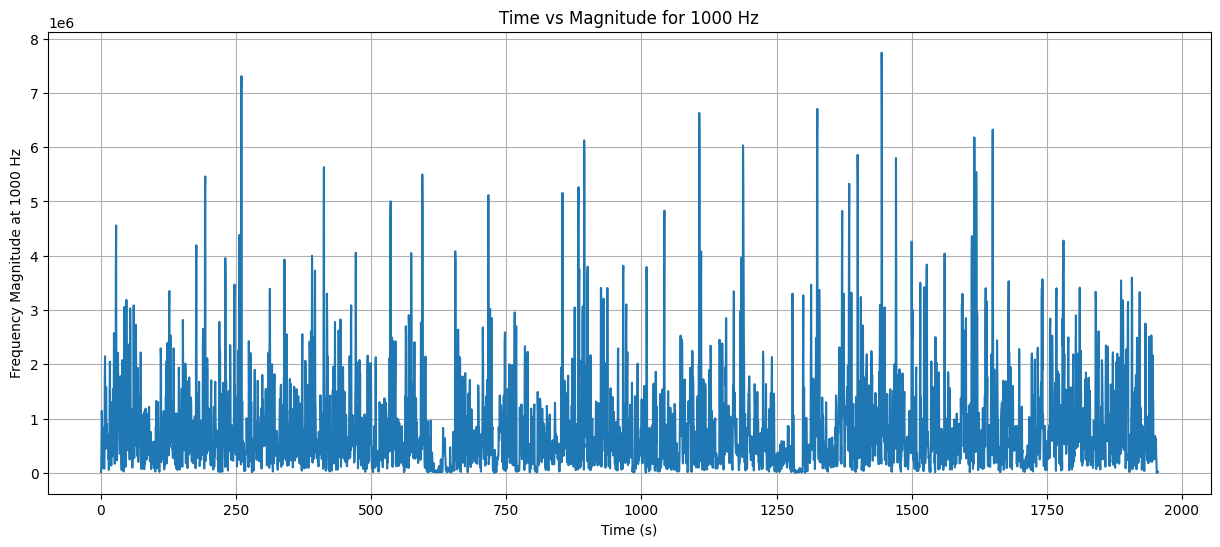

In [10]:
# 1000Hz 근처의 주파수 대 시간 시각화
target_freq = 1000
freq_bin = np.abs(np.linspace(0, sample_rate / 2, freq_data.shape[0]) - target_freq).argmin()
freq_at_target = freq_data[freq_bin, :]

plt.figure(figsize=(15, 6))
plt.plot(time_points, freq_at_target)
plt.xlabel("Time (s)")
plt.ylabel(f"Frequency Magnitude at {target_freq} Hz")
plt.title(f"Time vs Magnitude for {target_freq} Hz")
plt.grid(True)
plt.show()

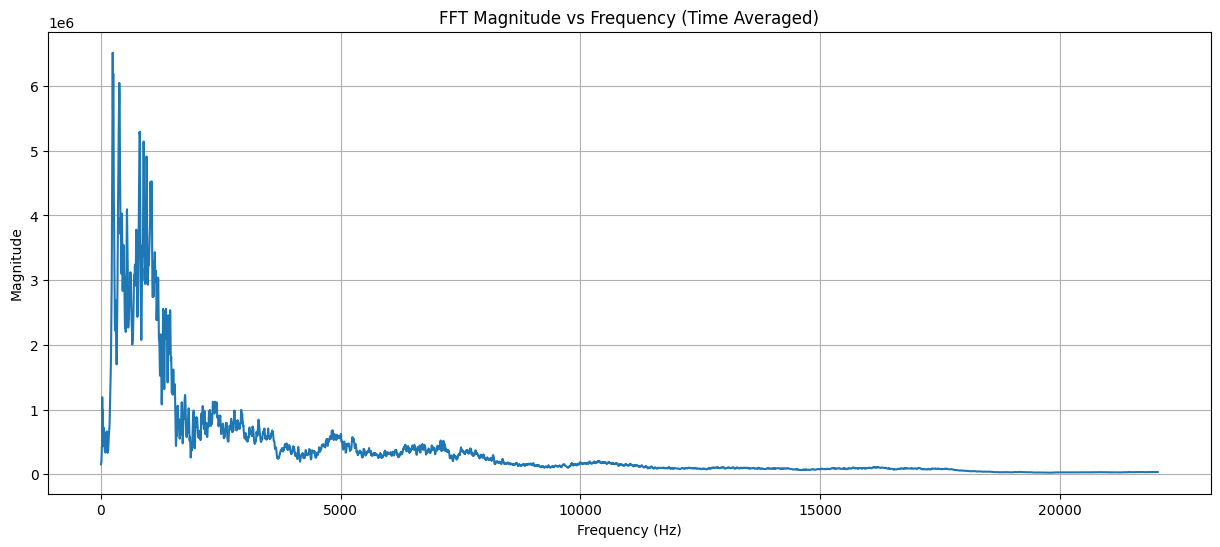

In [11]:
# FFT 분석 후 특정 주파수 대역을 추출하여 시각화
freq_band = np.linspace(0, sample_rate / 2, num=int(len(freq_data)/2))
freq_band_data = np.mean(freq_data[:len(freq_band)], axis=1)

plt.figure(figsize=(15, 6))
plt.plot(freq_band, freq_band_data)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT Magnitude vs Frequency (Time Averaged)")
plt.grid(True)
plt.show()

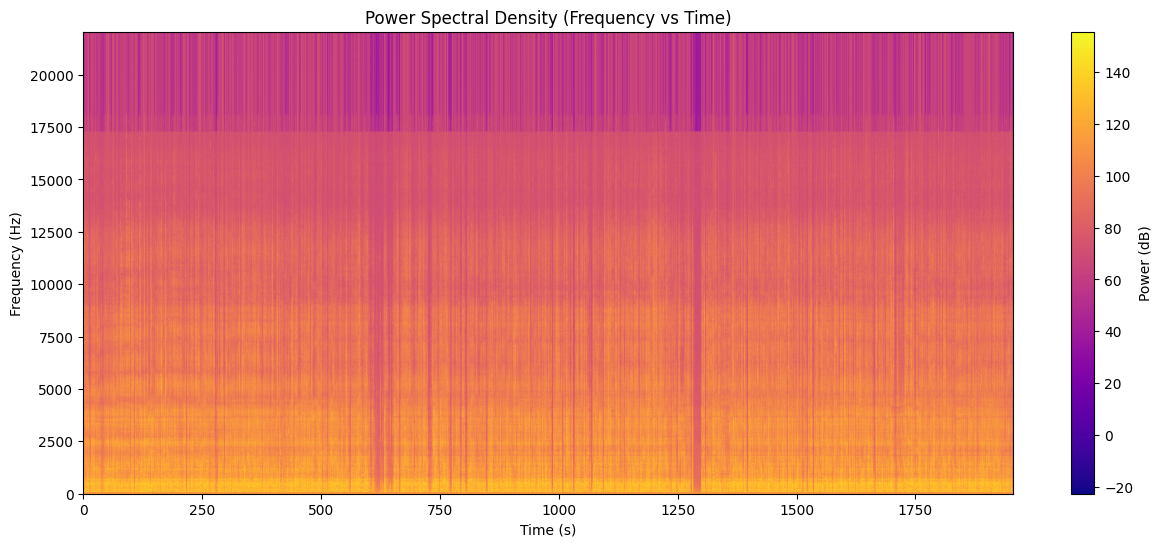

In [12]:
# 파워 스펙트럼 시각화 (로그 스케일)(2차원)
power_spectrum = np.abs(freq_data)**2

plt.figure(figsize=(15, 6))
plt.imshow(
    10 * np.log10(power_spectrum + 1e-10),
    aspect='auto',
    origin='lower',
    extent=[time_points.min(), time_points.max(), 0, sample_rate / 2],
    cmap='plasma'  # 파워 스펙트럼에 맞는 컬러맵
)
plt.colorbar(label="Power (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Power Spectral Density (Frequency vs Time)")
plt.show()